# 12.850 - Assignment 4  |  Bryce Corlett

## Formulate + Solve 2-D Elliptic Problem

My intitial thought for this assignment was to include an advection-diffusion problem in order to model the "diffusion" of suspended sediment through an approximate estuary. This idea may come back as my final project, but I thought it to be a bit too high of a hurdle to tackle for this assignment. As a result, I chose to model the 2-D Elliptic problem suggested as an example in class: the pressure field resulting from flow through a saturated porous medium. In this case, the initial equation for flow is:
\begin{equation}
    q = (u,v) = -(k^{x},k^{y}) * \nabla p
\end{equation}
with the incompressibility constraint ($\nabla * q = 0$), resulting in the following 2-D problem:
\begin{equation}
    \frac{\partial}{\partial x}\kappa_{1}\frac{\partial}{\partial x}p + \frac{\partial}{\partial y}\kappa_{2}\frac{\partial}{\partial y}p = f(x,y)
\end{equation}

In [1]:
#Import toolboxes to set up Python environment
from scipy import sparse #Allows me to create sparse matrices (i.e. not store all of the zeros in the 'A' matrix)
from scipy.sparse import linalg as linal
from numpy import * #To make matrices and do matrix manipulation
import matplotlib.pyplot as plt 
import matplotlib.cm as cm #Load colormaps

%matplotlib inline

Discretized, the equation becomes visually more complex, but easily solved through a series of loops:
\begin{equation}
    u_{j,k+1}\left[\frac{K_{k}}{\Delta z^{c}_{k+1} \Delta z^{f}_{k}}\right] - u_{j,k}\left[\frac{K_{k}}{\Delta z^{c}_{k+1} \Delta z^{f}_{k}} + \frac{K_{k-1}}{\Delta z^{c}_{k} \Delta z^{f}_{k}} \right] + u_{j,k-1}\left[\frac{K_{k-1}}{\Delta z^{c}_{k} \Delta z^{f}_{k}}\right] + u_{j+1,k}\left[\frac{K_{j}}{\Delta z^{c}_{j+1} \Delta z^{f}_{j}}\right] - u_{j,k}\left[\frac{K_{j}}{\Delta z^{c}_{j+1} \Delta z^{f}_{j}} + \frac{K_{j-1}}{\Delta z^{c}_{j} \Delta z^{f}_{j}} \right] + u_{j-1,k}\left[\frac{K_{j-1}}{\Delta z^{c}_{j} \Delta z^{f}_{j}}\right] = 0
\end{equation}

The decision to go with loops instead of matrix computations for this assignment was difficult, but the advantage of not storing your coefficients or large matrices within the solving routine led me to use loops as a way of anticipating future use of higher-resolution grids. 

## Formulate problem with initial conditions

The code below initializes the field according to a given x-length ($m$) and y-length ($n$), set diffusivity fields, and set axis-specific grid-resolution. As a first attempt, the code was run with uniform diffusivity, and Dirichlet boundary conditions (forcing a pressure of zero at all boundaries except the left, which is forced with a pressure of one).

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

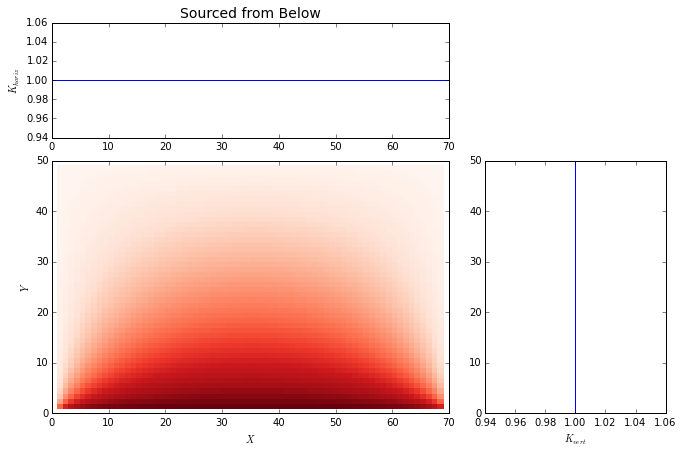

In [2]:
m=70 #X resolution
n=50 #Y resolution
k=0
w=1.5
tolerance = 1e-2

K=ones((n+1,1))
K = K[::-1] #reverse 
K2=ones((m+1,1))
Z_f=arange(0,n+2)#X
Z_c=arange(0,n+1)
Z_f2=arange(0,m+2)#Y
Z_c2=arange(0,m+1)

#Set up initial conditions
U = (zeros((n+1,m+1)))
B = (zeros((n+1,m+1)))

#Begin process
resid = 100.
U_old=[]
while resid > tolerance:
    #for q in range(0,1):
    U_old[:] = U; U_old = array(U_old)
    for j in range(1,n): #Start from left, and work right
        for k in range(1,m): #Start from bed and work to surface
            #Initialize values
            A1=0.;A2=0.;A3=0.;A4=0.;A5=0.; 
            #Boundary Velocities (Dirichlet)
            UL=1.;UR=0.;UB=0.;UT=0.;

            #Calculate Terms + Implement Gauss-Seidel
            #j-1,k
            if j==1:
                A1 = +(K[j-1]/((Z_f[j]-Z_f[j-1])*(Z_c[j]-Z_c[j-1])) )*UL
            elif j>1:
                A1 = +(K[j-1]/((Z_f[j]-Z_f[j-1])*(Z_c[j]-Z_c[j-1])) )*U[j-1,k]
            #j+1,k
            if j==n:
                A2 = +(K[j]/((Z_f[j]-Z_f[j-1])*(Z_c[j+1]-Z_c[j])) )*UR
            elif j<n:
                A2 = +(K[j]/((Z_f[j]-Z_f[j-1])*(Z_c[j+1]-Z_c[j])) )*U_old[j+1,k]
            #j,k
            A3 = -( (K[j-1]/((Z_f[j]-Z_f[j-1])*(Z_c[j]-Z_c[j-1]))) + (K[j]/((Z_f[j]-Z_f[j-1])*(Z_c[j+1]-Z_c[j])))) -( (K2[k-1]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k]-Z_c2[k-1]))) + (K2[k]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k+1]-Z_c2[k]))))
            #j,k-1
            if k==1:
                A4 = +(K2[k-1]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k]-Z_c2[k-1])) )*UB
            elif k>1:
                A4 = +(K2[k-1]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k]-Z_c2[k-1])) )*U[j,k-1]
            #j,k+1
            if k==m:
                A5 = +(K2[k]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k+1]-Z_c2[k])))*UT
            elif k<m:
                A5 = +(K2[k]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k+1]-Z_c2[k])))*U_old[j,k+1]

            #Gauss-Seidel
            U_new = (B[j,k] - ( A1 + A2 + A4 + A5 ))/A3
            #SOR
            U[j,k] = (w*float(U_new)) + ((1-w)*U_old[j,k])
    resid = abs(((U - U_old)*100.0)).max()
    print('.'),

plt.figure(figsize=(11,7))
plt.subplot2grid((3,3), (0,0), colspan=2)
plt.plot(arange(0,m+1),K2)
plt.ylabel('$K_{horiz}$')
plt.title('Sourced from Below',fontsize=14)
plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
plt.pcolor(arange(1,m),arange(1,n),U[1:n,1:m],cmap=cm.Reds)
plt.xlabel('$X$');plt.ylabel('$Y$')
plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)
plt.plot(K,arange(0,n+1))
plt.xlabel('$K_{vert}$')
plt.show()


## Review

The iteration scheme has done a decent job of producing a diffused pressure field, in which the bottom boundary is forced to be one, and has shown that the iterative scheme works and relaxes quickly toward the steady-state solution. It is important to test the solution under varying conditions, however, which leads me to my next test: varying diffusivity fields but the same boundary condition. Below, I show the effect of horizontal diffusivity gradients on the equilibrium state of our grid.

## X-varying Diffusivity

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

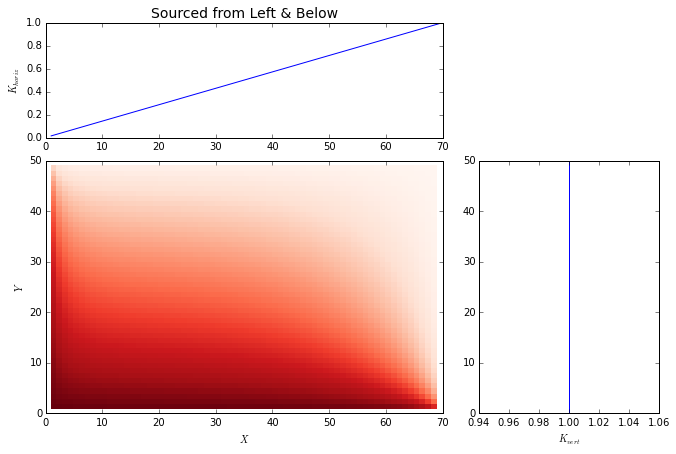

In [3]:
m=70 #X resolution
n=50 #Y resolution
k=0
w=1.5
tolerance = 1e-2

K=ones((n+1,1))
K = K[::-1] #reverse
K2=arange(1,m+1)/float(max(arange(1,m+1)));#ones((n+1,1))
Z_f=arange(0,n+2)#X
Z_c=arange(0,n+1)
Z_f2=arange(0,m+2)#Y
Z_c2=arange(0,m+1)

#Set up initial conditions
U = (zeros((n+1,m+1)))
B = (zeros((n+1,m+1)))

resid = 100.
U_old=[]
while resid > tolerance:
    #for q in range(0,1):
    U_old[:] = U; U_old = array(U_old)
    for j in range(1,n): #Start from left, and work right
        for k in range(1,m): #Start from bed and work to surface
            #Initialize values
            A1=0.;A2=0.;A3=0.;A4=0.;A5=0.; 
            #Boundary Velocities (Dirichlet)
            UL=1.;UR=0.;UB=1.;UT=0.;

            #Calculate Terms + Implement Gauss-Seidel
            #j-1,k
            if j==1:
                A1 = +(K[j-1]/((Z_f[j]-Z_f[j-1])*(Z_c[j]-Z_c[j-1])) )*UL
            elif j>1:
                A1 = +(K[j-1]/((Z_f[j]-Z_f[j-1])*(Z_c[j]-Z_c[j-1])) )*U[j-1,k]
            #j+1,k
            if j==n:
                A2 = +(K[j]/((Z_f[j]-Z_f[j-1])*(Z_c[j+1]-Z_c[j])) )*UR
            elif j<n:
                A2 = +(K[j]/((Z_f[j]-Z_f[j-1])*(Z_c[j+1]-Z_c[j])) )*U_old[j+1,k]
            #j,k
            A3 = -( (K[j-1]/((Z_f[j]-Z_f[j-1])*(Z_c[j]-Z_c[j-1]))) + (K[j]/((Z_f[j]-Z_f[j-1])*(Z_c[j+1]-Z_c[j])))) -( (K2[k-1]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k]-Z_c2[k-1]))) + (K2[k]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k+1]-Z_c2[k]))))
            #j,k-1
            if k==1:
                A4 = +(K2[k-1]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k]-Z_c2[k-1])) )*UB
            elif k>1:
                A4 = +(K2[k-1]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k]-Z_c2[k-1])) )*U[j,k-1]
            #j,k+1
            if k==m:
                A5 = +(K2[k]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k+1]-Z_c2[k])))*UT
            elif k<m:
                A5 = +(K2[k]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k+1]-Z_c2[k])))*U_old[j,k+1]
                
            #Gauss-Seidel
            U_new = (B[j,k] - ( A1 + A2 + A4 + A5 ))/A3
            #SOR
            U[j,k] = (w*float(U_new)) + ((1-w)*U_old[j,k])
    resid = abs(((U - U_old)*100.0)).max()
    print('.'),
    
#print(resid.max())
plt.figure(figsize=(11,7))
plt.subplot2grid((3,3), (0,0), colspan=2)
plt.plot(arange(1,m+1),K2)
plt.ylabel('$K_{horiz}$')
plt.title('Sourced from Left & Below',fontsize=14)
plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
plt.pcolor(arange(1,m),arange(1,n),U[1:n,1:m],cmap=cm.Reds)
plt.xlabel('$X$');plt.ylabel('$Y$')
plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)
plt.plot(K,arange(0,n+1))
plt.xlabel('$K_{vert}$')
plt.show()

In this case, the large diffusivity (from a small $K$, and ability to sustain large gradients) on the left-hand side of the grid has overwhelmed the cells near the boundary. As the tolerance is adjusted, the strong pressure signal at the base diffuses up into the grid at varying rates, producing the gradient in pressure seen above. As a final test of the dirichlet boundary conditions, I show below the effects of varying diffusivity fields in both $x$ and $y$. 

## X & Y-varying Diffusivity

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

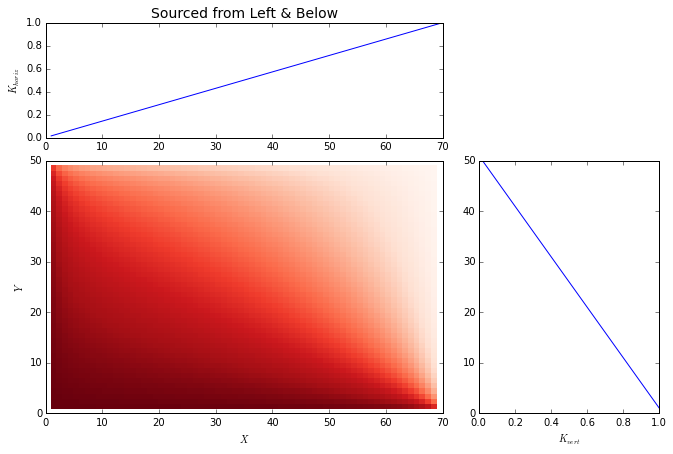

In [4]:
m=70 #X resolution
n=50 #Y resolution
k=0
w=1.5
tolerance = 1e-2

K=arange(1,n+1)/float(max(arange(1,n+1)));#ones((n+1,1))
K = K[::-1] #reverse
K2=arange(1,m+1)/float(max(arange(1,m+1)));#ones((n+1,1))
Z_f=arange(0,n+2)#X
Z_c=arange(0,n+1)
Z_f2=arange(0,m+2)#Y
Z_c2=arange(0,m+1)

#Set up initial conditions
U = (zeros((n+1,m+1)))
B = (zeros((n+1,m+1)))

resid = 100.
U_old=[]
while resid > tolerance:
    #for q in range(0,1):
    U_old[:] = U; U_old = array(U_old)
    for j in range(1,n): #Start from left, and work right
        for k in range(1,m): #Start from bed and work to surface
            #Initialize values
            A1=0.;A2=0.;A3=0.;A4=0.;A5=0.; 
            #Boundary Velocities (Dirichlet)
            UL=1.;UR=0.;UB=1.;UT=0.;

            #Calculate Terms + Implement Gauss-Seidel
            #j-1,k
            if j==1:
                A1 = +(K[j-1]/((Z_f[j]-Z_f[j-1])*(Z_c[j]-Z_c[j-1])) )*UL
            elif j>1:
                A1 = +(K[j-1]/((Z_f[j]-Z_f[j-1])*(Z_c[j]-Z_c[j-1])) )*U[j-1,k]
            #j+1,k
            if j==n:
                A2 = +(K[j]/((Z_f[j]-Z_f[j-1])*(Z_c[j+1]-Z_c[j])) )*UR
            elif j<n:
                A2 = +(K[j]/((Z_f[j]-Z_f[j-1])*(Z_c[j+1]-Z_c[j])) )*U_old[j+1,k]
            #j,k
            A3 = -( (K[j-1]/((Z_f[j]-Z_f[j-1])*(Z_c[j]-Z_c[j-1]))) + (K[j]/((Z_f[j]-Z_f[j-1])*(Z_c[j+1]-Z_c[j])))) -( (K2[k-1]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k]-Z_c2[k-1]))) + (K2[k]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k+1]-Z_c2[k]))))
            #j,k-1
            if k==1:
                A4 = +(K2[k-1]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k]-Z_c2[k-1])) )*UB
            elif k>1:
                A4 = +(K2[k-1]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k]-Z_c2[k-1])) )*U[j,k-1]
            #j,k+1
            if k==m:
                A5 = +(K2[k]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k+1]-Z_c2[k])))*UT
            elif k<m:
                A5 = +(K2[k]/((Z_f2[k]-Z_f2[k-1])*(Z_c2[k+1]-Z_c2[k])))*U_old[j,k+1]
                
            #Gauss-Seidel
            U_new = (B[j,k] - ( A1 + A2 + A4 + A5 ))/A3
            #SOR
            U[j,k] = (w*float(U_new)) + ((1-w)*U_old[j,k])
    resid = abs(((U - U_old)*100.0)).max()
    print('.'),
    
#print(resid.max())
plt.figure(figsize=(11,7))
plt.subplot2grid((3,3), (0,0), colspan=2)
plt.plot(arange(1,m+1),K2)
plt.ylabel('$K_{horiz}$')
plt.title('Sourced from Left & Below',fontsize=14)
plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
plt.pcolor(arange(1,m),arange(1,n),U[1:n,1:m],cmap=cm.Reds)
plt.xlabel('$X$');plt.ylabel('$Y$')
plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)
plt.plot(K,arange(1,n+1))
plt.xlabel('$K_{vert}$')
plt.show()

##What was learned

In the end, I've learned that my coding mistakes have come about in the process of translating the discrete equation into codes to be implemented in the iterative procedure. By going back through my code multiple times, I was able to iron out the bugs, and produce realistic results under the given conditions. The process of incorporating two dimensions into a single matrix was possible, but I chose the simpler loop method as a way of avoiding matrices of size 2N$^{2}$ by 2N$^{2}$, where N is the number of points in the discrete grid that the solution is solving for. As of yet, I am not sure that using sparse matrices would match the iterative process in terms of speed. Determining the faster method requires further investigation, but it would be helpful to know, going forward into more complex and demanding problems.

The looping procedure appears to work well, but without sweeping back and forth in the iterations, the error of the system is driven by the error of the initial cell. The "sweeping" still needs to be implemented, but overall, the adjustment of the previous models from 1D to 2D appears to have been successful.